## Import libraries

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from numpy import random as rd
import os
import json
from sklearn.decomposition import PCA
import multiprocessing, multiprocessing.pool
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import Counter
from sklearn.manifold import TSNE
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn import tree
import miner_py3 as miner
%matplotlib inline
plt.style.use('ggplot')

## Create directory to save output files

In [2]:
# Path to the miner directory
input_path = os.path.join(os.path.expanduser('~'),'Desktop','GitHub','miner','miner')

# create name for results folder where output files will be saved
resultsFolder = "results_miner3_stabilized_tmp"

# name of the folder containing the miner network
#networkFolder = "miner_network_results"
networkFolder = "results_minCorrelation_0o2_50_allFiles"

# create results directory
resultsDirectory = os.path.join(os.path.split(os.getcwd())[0],resultsFolder)
if not os.path.isdir(resultsDirectory):
    os.mkdir(resultsDirectory)

## Load primary data

In [3]:
# Load expression Data
expressionFile = os.path.join(input_path,"data","expression","IA12Zscore.csv")
#expressionData = pd.read_csv(expressionFile,index_col=0,header=0)
expressionData, conversionTable = miner.preprocess(expressionFile)

# Load mutations
common_mutations = pd.read_csv(os.path.join(input_path,'data','mutations','commonMutations.csv'),index_col=0,header=0)
translocations = pd.read_csv(os.path.join(input_path,'data','mutations','translocationsIA12.csv'),index_col=0,header=0)
cytogenetics = pd.read_csv(os.path.join(input_path,'data','mutations','cytogenetics.csv'),index_col=0,header=0)
cytogenetics = cytogenetics.loc[:,list(set(cytogenetics.columns)&set(expressionData.columns))]
common_patients_mutations_translocations = list(set(translocations.columns)&set(common_mutations.columns))
mutation_matrix = pd.concat([common_mutations.loc[:,common_patients_mutations_translocations],translocations.loc[:,common_patients_mutations_translocations]],axis=0)

#If previous results exist, use miner.read_json to load them
revisedClusters = miner.read_json(os.path.join(input_path,networkFolder,"coexpressionDictionary.json"))
coexpressionModules = miner.read_json(os.path.join(input_path,networkFolder,"coexpressionModules.json"))
regulonModules = miner.read_json(os.path.join(input_path,networkFolder,"regulons.json"))
mechanisticOutput = miner.read_json(os.path.join(input_path,networkFolder,"mechanisticOutput.json"))
regulonDf = pd.read_csv(os.path.join(input_path,networkFolder,"regulonDf.csv"),index_col=0,header=0)
overExpressedMembersMatrix = pd.read_csv(os.path.join(input_path,networkFolder,"overExpressedMembers.csv"),index_col=0,header=0)
overExpressedMembersMatrix.index = np.array(overExpressedMembersMatrix.index).astype(str)
underExpressedMembersMatrix = pd.read_csv(os.path.join(input_path,networkFolder,"underExpressedMembers.csv"),index_col=0,header=0)
underExpressedMembersMatrix.index = np.array(underExpressedMembersMatrix.index).astype(str)
eigengenes = pd.read_csv(os.path.join(input_path,networkFolder,"eigengenes.csv"),index_col=0,header=0)
eigengenes.index = np.array(underExpressedMembersMatrix.index).astype(str)

#Load table for converting gene names
id_table_path = os.path.join(os.path.expanduser("~"),"Desktop","GitHub","miner","miner","data","identifier_mappings.txt")
id_table = pd.read_csv(id_table_path,sep="\t")
id_table = id_table[id_table["Source"] == "Gene Name"]
id_table.index = id_table.iloc[:,0]

completed identifier conversion.
16216 genes were converted.


## Define patient populations

In [4]:
baseline_patients = [name for name in expressionData.columns if name.split("_")[2]=='1']
relapse_patients = [name for name in expressionData.columns if name.split("_")[2]=='2']
all_relapse_patients = [name for name in expressionData.columns if name.split("_")[2]!='1']
print('Baseline:',len(baseline_patients),'First relapse:',len(relapse_patients),'\nAny relapse:',len(all_relapse_patients))

Baseline: 779 First relapse: 56 
Any relapse: 102


## Load network

In [5]:
# Load Causal Mechanistic Network
filtered_causal_results = pd.read_csv(os.path.join(input_path,networkFolder,"filteredCausalResults.csv"),index_col=0,header=0)

In [6]:
# Load transcriptional programs
transcriptional_programs = miner.read_json(os.path.join(input_path,networkFolder,'transcriptional_programs.json'))
program_list = [transcriptional_programs[str(key)] for key in range(len(transcriptional_programs.keys()))]

In [7]:
# Load transcriptional states
transcriptional_states = miner.read_json(os.path.join(input_path,networkFolder,'transcriptional_states.json'))
states_list = [transcriptional_states[str(key)] for key in range(len(transcriptional_states.keys()))]
final_state = list(set(expressionData.columns)-set(np.hstack(states_list)))
if len(final_state)>0:
    states_list.append(final_state)
states = states_list.copy()
diff_matrix_MMRF = overExpressedMembersMatrix-underExpressedMembersMatrix

In [8]:
# Create dictionary of program genes
# make dictionary of genes by program
pr_genes = {}
for i in range(len(program_list)):
    rgns = program_list[i]
    genes = []
    for r in rgns:
        genes.append(regulonModules[r])
    genes = list(set(np.hstack(genes)))
    pr_genes[i] = genes

## Calculate network activity

In [9]:
import importlib
importlib.reload(miner)

network_activity_overexpressed = miner.networkActivity(regulon_matrix=regulonDf.copy(),
                                                 reference_matrix=overExpressedMembersMatrix.copy(),
                                                 minRegulons = 2)
network_activity_underexpressed = miner.networkActivity(regulon_matrix=regulonDf.copy(),
                                                 reference_matrix=underExpressedMembersMatrix.copy(),
                                                 minRegulons = 2)
network_activity_diff = miner.networkActivity(regulon_matrix=regulonDf.copy(),
                                                 reference_matrix=diff_matrix_MMRF.copy(),
                                                 minRegulons = 2)

## Plot baseline versus relapse network activity

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


(-0.05, 0.6)

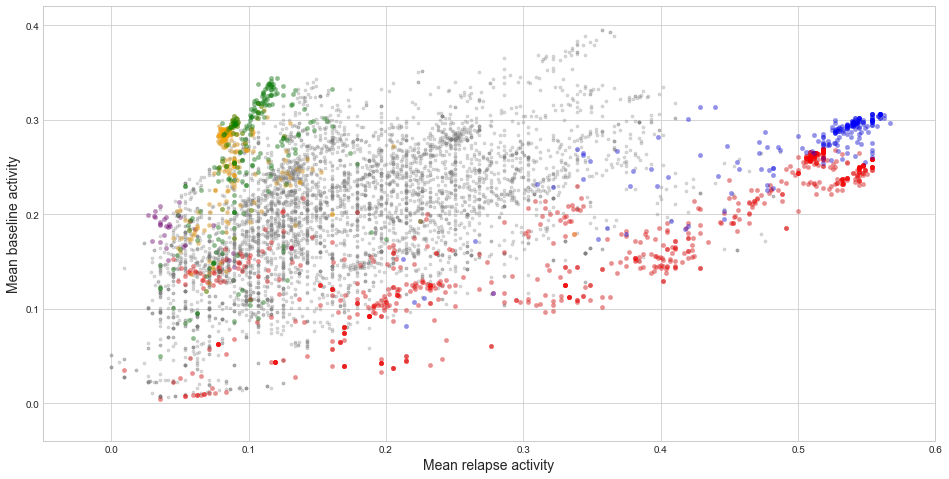

In [10]:
plt.figure(figsize=(16,8))
plt.style.use('seaborn-whitegrid')

baseline_activity = np.mean(network_activity_overexpressed.loc[:,baseline_patients],axis=1)
relapse_activity = np.mean(network_activity_overexpressed.loc[:,relapse_patients],axis=1)

baseline_activity_134 = np.mean(network_activity_overexpressed.loc[pr_genes[134],baseline_patients],axis=1)
relapse_activity_134 = np.mean(network_activity_overexpressed.loc[pr_genes[134],relapse_patients],axis=1)

baseline_activity_68 = np.mean(network_activity_overexpressed.loc[pr_genes[68],baseline_patients],axis=1)
relapse_activity_68 = np.mean(network_activity_overexpressed.loc[pr_genes[68],relapse_patients],axis=1)

baseline_activity_34 = np.mean(network_activity_overexpressed.loc[pr_genes[34],baseline_patients],axis=1)
relapse_activity_34 = np.mean(network_activity_overexpressed.loc[pr_genes[34],relapse_patients],axis=1)

baseline_activity_0 = np.mean(network_activity_overexpressed.loc[pr_genes[0],baseline_patients],axis=1)
relapse_activity_0 = np.mean(network_activity_overexpressed.loc[pr_genes[0],relapse_patients],axis=1)

baseline_activity_4 = np.mean(network_activity_overexpressed.loc[pr_genes[4],baseline_patients],axis=1)
relapse_activity_4 = np.mean(network_activity_overexpressed.loc[pr_genes[4],relapse_patients],axis=1)


plt.scatter(relapse_activity,baseline_activity,alpha=0.3,s=10,color="gray")
plt.scatter(relapse_activity_134,baseline_activity_134,alpha=0.3,s=20,color="red")
plt.scatter(relapse_activity_68,baseline_activity_68,alpha=0.3,s=20,color="blue")
plt.scatter(relapse_activity_34,baseline_activity_34,alpha=0.3,s=20,color="purple")
plt.scatter(relapse_activity_0,baseline_activity_0,alpha=0.3,s=20,color="orange")
plt.scatter(relapse_activity_4,baseline_activity_4,alpha=0.3,s=20,color="green")

plt.ylabel("Mean baseline activity",FontSize=14)
plt.xlabel("Mean relapse activity",FontSize=14)
plt.ylim(-0.04,0.42)
plt.xlim(-0.05,0.6)
#plt.savefig(os.path.join(resultsDirectory,"dotplot_relapse.pdf"),bbox_inches="tight")


## Identify selected genes from activity plot

In [11]:
# Select window of genes to identify enriched programs
condition_1 = relapse_activity.index[relapse_activity>0.5]
condition_2 = baseline_activity.index[baseline_activity<0.99]

selected_genes = list(set(condition_1)&set(condition_2))
miner.gene_conversion(selected_genes)

#Identify transcriptional programs enriched with selected genes
for p in range(len(pr_genes)):
    overlap = len(set(pr_genes[p])&set(selected_genes))
    if overlap >=20:
        print(p)

querying 1-351...done.
Finished.
68
134


In [16]:
#Convert gene identifiers to HGNC
conversion = miner.gene_conversion(list(set(pr_genes[134])&set(selected_genes)),
                      id_table=id_table,
                      input_type="ensembl",output_type="symbol",list_symbols=True)

#Save genes to file
np.savetxt(os.path.join(resultsDirectory,"134_relapse_genes.txt"),conversion,fmt="%1.50s")

## Compare expression to network activity at baseline and relapse

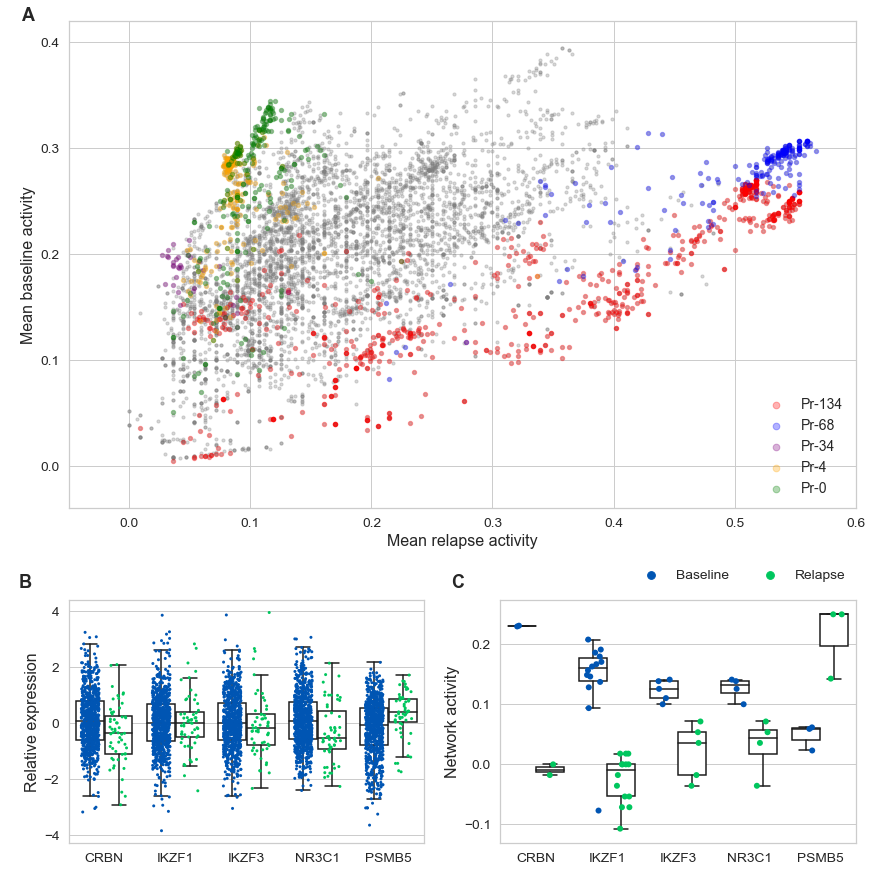

In [126]:
#Plot data
fig = plt.figure(constrained_layout=True,figsize=(12,12))
sns.set(style="whitegrid",font_scale = 1.25)

# Set figure axes
n_rows = 2
n_cols = 2
gs = fig.add_gridspec(n_rows, n_cols,height_ratios= [2,1])
axs = []

#Scatterplot
fig.add_subplot(gs[0,:])
ax = plt.gca()
baseline_activity = np.mean(network_activity_overexpressed.loc[:,baseline_patients],axis=1)
relapse_activity = np.mean(network_activity_overexpressed.loc[:,relapse_patients],axis=1)

baseline_activity_134 = np.mean(network_activity_overexpressed.loc[pr_genes[134],baseline_patients],axis=1)
relapse_activity_134 = np.mean(network_activity_overexpressed.loc[pr_genes[134],relapse_patients],axis=1)

baseline_activity_68 = np.mean(network_activity_overexpressed.loc[pr_genes[68],baseline_patients],axis=1)
relapse_activity_68 = np.mean(network_activity_overexpressed.loc[pr_genes[68],relapse_patients],axis=1)

baseline_activity_34 = np.mean(network_activity_overexpressed.loc[pr_genes[34],baseline_patients],axis=1)
relapse_activity_34 = np.mean(network_activity_overexpressed.loc[pr_genes[34],relapse_patients],axis=1)

baseline_activity_0 = np.mean(network_activity_overexpressed.loc[pr_genes[0],baseline_patients],axis=1)
relapse_activity_0 = np.mean(network_activity_overexpressed.loc[pr_genes[0],relapse_patients],axis=1)

baseline_activity_4 = np.mean(network_activity_overexpressed.loc[pr_genes[4],baseline_patients],axis=1)
relapse_activity_4 = np.mean(network_activity_overexpressed.loc[pr_genes[4],relapse_patients],axis=1)


a1 = plt.scatter(relapse_activity,baseline_activity,alpha=0.3,s=10,color="gray")
a2 = plt.scatter(relapse_activity_134,baseline_activity_134,alpha=0.3,s=20,color="red")
a3 = plt.scatter(relapse_activity_68,baseline_activity_68,alpha=0.3,s=20,color="blue")
a4 = plt.scatter(relapse_activity_34,baseline_activity_34,alpha=0.3,s=20,color="purple")
a5 = plt.scatter(relapse_activity_0,baseline_activity_0,alpha=0.3,s=20,color="orange")
a6 = plt.scatter(relapse_activity_4,baseline_activity_4,alpha=0.3,s=20,color="green")

plt.ylabel("Mean baseline activity",FontSize=16)
plt.xlabel("Mean relapse activity",FontSize=16)
plt.ylim(-0.04,0.42)
plt.xlim(-0.05,0.6)

handles = [a2,a3,a4,a5,a6]
labels = ["Pr-134","Pr-68","Pr-34","Pr-4","Pr-0"]
ax.legend(handles,labels,fontsize=14,loc='lower right',markerscale=1.5)

axs.append(ax)


# Fill second subplot
fig.add_subplot(gs[1,0])
#sns.stripplot(data=exp_data, x='Target', y='Expression',hue="Timepoint",
#                      dodge=True,jitter=0.25,size=3,palette="viridis")

ax_1 = sns.stripplot(data=exp_data, x='Target', y='Expression',hue="Timepoint",
                      dodge=True,jitter=0.25,size=3,palette={"Baseline":'#0055b3',"Relapse":'#00C65E'})#00C756
ax_2 = sns.boxplot(data=exp_data, x='Target', y='Expression',hue="Timepoint",
                  dodge=True,fliersize=0,palette={"Baseline":'#0055b3',"Relapse":'#00C65E'})

#Black and white boxplots
plt.setp(ax_2.artists, edgecolor = 'k', facecolor='w')
plt.setp(ax_2.lines, color='k')

# # Add transparency to colors
# for patch in ax.artists:
#     r, g, b, a = patch.get_facecolor()
#     patch.set_facecolor((r, g, b, 0.7))
    
ax_2.legend_.remove()
#ax.set_ylabel("\n")
ax_2.set_ylabel("\nRelative expression",FontSize=16)
ax_2.set_xlabel("")
#axs.append(ax_1)
axs.append(ax_2)

#ax.set_xlabel("")
# Fill third subplot
fig.add_subplot(gs[1,1])

ax_3 = sns.boxplot(data=reg_data, x='Target', y='Mean Regulon Activity',hue="Timepoint",
                  dodge=True,fliersize=0,palette={"Baseline":'#0055b3',"Relapse":'#00C65E'})
    
plt.setp(ax_3.artists, edgecolor = 'k', facecolor='w')
plt.setp(ax_3.lines, color='k')
    
ax_4 = sns.stripplot(data=reg_data, x='Target', y='Mean Regulon Activity',hue="Timepoint",
                      dodge=True,jitter=0.25,size=6,palette={"Baseline":'#0055b3',"Relapse":'#00C65E'})

        
#ax.set_ylabel("\n")
ax_3.set_ylabel("Network activity",FontSize=16)
ax_3.set_xlabel("")
ax_4.legend(handles = ax_4.get_legend_handles_labels()[0][2:],labels = ax_4.get_legend_handles_labels()[1][2:],loc='center left', bbox_to_anchor=(0.35, 1.1), ncol=2)
#axs.append(ax_3)
axs.append(ax_4)

import string
for n, ax in enumerate(axs):
    left_indent = -0.14
    top_indent = 1.05
    if n == 0:
        left_indent = -0.06
        top_indent = 1.0
    ax.text(left_indent, top_indent, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=18, weight='bold')
    
plt.savefig(os.path.join(resultsDirectory,"figure_6.png"),dpi=400)
